In [9]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.XAS_functions import *
from scipy.stats.stats import pearsonr


import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [2]:
pgroup='p20537'
runnumber = 154
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0154


'/sf/alvra/data/p20537/raw/run0154-jet_scan/meta/scan.json'

In [13]:
fc = FileChooser('/sf/alvra/data/p20537/raw')  
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [14]:
jsonfile = copy.copy(fc.selected)

In [15]:
quantile_corr = 0.6

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110
#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

#Signal_APD1, IzeroFEL, correlation, Position_mm = \
#XAS_scan_1diode_static(fc.selected, detector_XAS_1, detector_Izero, quantile_corr)

Signal_APD1, Signal_APD2, IzeroFEL, correlation1, correlation2, Position_mm = \
XAS_scan_2diodes_static(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)

Processing: run0154-jet_scan
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   151 / 151 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  151 / 151 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  151 / 151 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 151 / 151 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 151 / 151 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
(89,) shots out of (151,) survived
(89,) shots out of (151,) survived
Step 61 of 61: Processed acq0061
correlation Diode1 (all shots) = 0.7594380671534607
correlation Diode2 (all shots) = -0.05146823788926234


## Plot only 1 diode

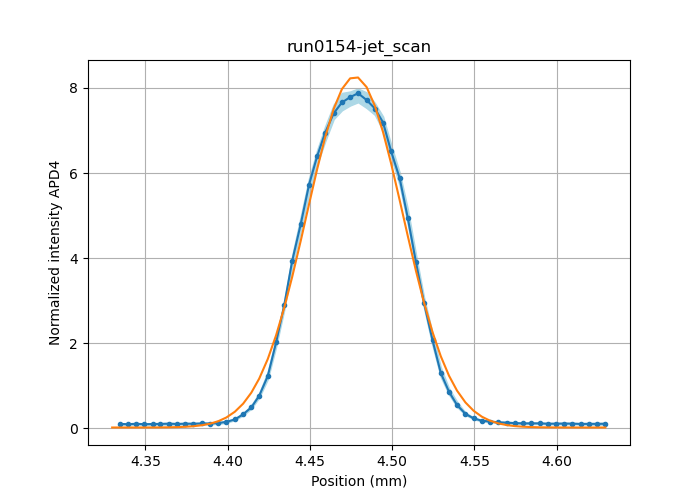

Center position = 4.477 mm
Width = 68.901 um


In [16]:
Int_APD1 = Signal_APD1[:,0]
err_low_APD1 = Signal_APD1[:,1]
err_high_APD1 = Signal_APD1[:,2]

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Position_mm, Int_APD1)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Position_mm, Int_APD1)                  # calculate the fit
Int_fit = fit.eval(Position_mm)            # evaluate the curve for plotting

center = fit.popt[0]
width = fit.popt[2]*2.355

plt.figure(figsize=(7,5))
plt.title(jsonfile.split('/')[-3])
plt.plot(Position_mm[1:], Int_APD1[1:], label='direction X, APD1, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Position_mm[1:], err_low_APD1[1:], err_high_APD1[1:], color='lightblue')
plt.plot(Position_mm, Int_fit)
plt.xlabel("Position (mm)")
plt.ylabel("Normalized intensity APD4")

plt.grid()
plt.show()

print("Center position = {:.3f} mm".format(center))
print("Width = {:.3f} um".format(width*1000))
#print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

## Plot 2 diodes

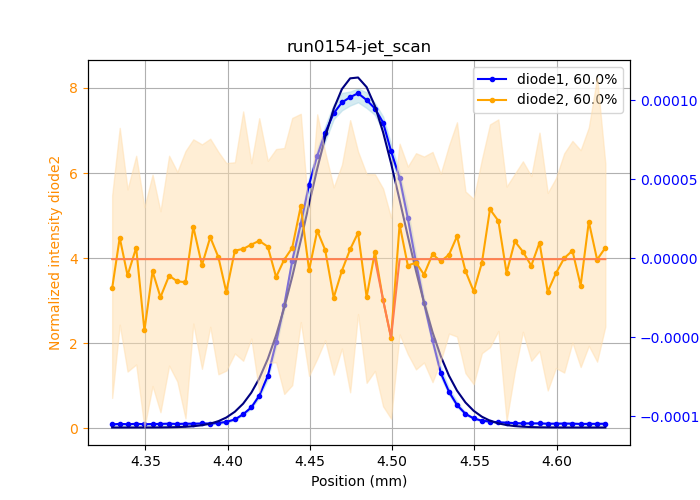

In [18]:
Int_APD1 = Signal_APD1[:,0]
err_low_APD1 = Signal_APD1[:,1]
err_high_APD1 = Signal_APD1[:,2]

Int_APD2 = Signal_APD2[:,0]
err_low_APD2 = Signal_APD2[:,1]
err_high_APD2 = Signal_APD2[:,2]

###########################################

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Position_mm, Int_APD1)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
fit.fit(Position_mm, Int_APD1)                  # calculate the fit
Int_fit1 = fit.eval(Position_mm)            # evaluate the curve for plotting
center1 = fit.popt[0]
width1 = fit.popt[2]*2.355

fit.estimate(Position_mm, Int_APD2)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
fit.fit(Position_mm, Int_APD2)                  # calculate the fit
Int_fit2 = fit.eval(Position_mm)            # evaluate the curve for plotting
center2 = fit.popt[0]
width2 = fit.popt[2]*2.355

###########################################

fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

lns1 = ax1.plot(Position_mm, Int_APD1, label='diode1, {}%'.format(quantile_corr*100),marker='.', color='b')
ax1.fill_between(Position_mm, err_low_APD1, err_high_APD1, color='lightblue', alpha = 0.5)
ax1.plot(Position_mm, Int_fit1, color='navy')

lns2 = ax2.plot(Position_mm, Int_APD2, label='diode2, {}%'.format(quantile_corr*100),marker='.', color='orange')
ax2.fill_between(Position_mm, err_low_APD2, err_high_APD2, color='navajowhite', alpha = 0.5)
ax2.plot(Position_mm, Int_fit2, color='coral')


plt.title(jsonfile.split('/')[-3])

ax1.set_xlabel("Position (mm)")

ax1.set_ylabel ("Normalized intensity diode2")
ax1.tick_params(axis='y', colors='darkorange')
ax1.yaxis.label.set_color('darkorange')

ax2.set_ylabel ("Normalized intensity diode1")
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')


leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
#ax1.axvline(6.615)
ax1.grid()

plt.show()